# Cluster Interpretation: Mental Health in Tech 2016

## 1. Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

RUN = 'run_02'

df = pd.read_csv(f'../../data/{RUN}/clustered/clustered_data.csv')

## 2. Cluster Overview

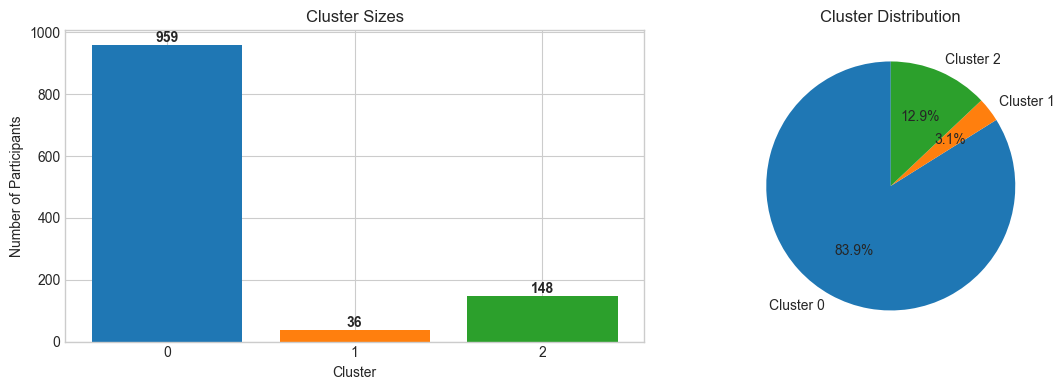

In [2]:
cluster_counts = df['cluster'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colors = plt.cm.tab10(range(len(cluster_counts)))

axes[0].bar(cluster_counts.index, cluster_counts.values, color=colors)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Number of Participants')
axes[0].set_title('Cluster Sizes')
axes[0].set_xticks(cluster_counts.index)
for i, v in enumerate(cluster_counts.values):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

axes[1].pie(cluster_counts.values, labels=[f'Cluster {i}' for i in cluster_counts.index],
            autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Cluster Distribution')

plt.tight_layout()
os.makedirs(f'../../plots/{RUN}', exist_ok=True)
plt.savefig(f'../../plots/{RUN}/cluster_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Define Feature Categories

In [3]:
feature_cols = [col for col in df.columns if col != 'cluster']

used_features = set()

def categorize(cols, keywords, exclude_keywords=None):
    result = []
    for col in cols:
        if col in used_features:
            continue
        if any(x in col for x in keywords):
            if exclude_keywords and any(x in col.lower() for x in exclude_keywords):
                continue
            result.append(col)
            used_features.add(col)
    return result

# 1. Demographic
demographic_features = categorize(feature_cols, 
    ['age', 'gender', 'country_live', 'country_work'])

# 2. Workplace
workplace_features = categorize(feature_cols,
    ['self-employed', 'employees', 'remotely', 'position_', 'tech company'])

# 3. Mental Health Status (personal)
mental_health_status = categorize(feature_cols,
    ['diagnosed_', 'currently have', 'in the past', 'family history', 
     'sought treatment', 'interferes with your work', 'medical professional'])

# 4. Previous Employer
previous_employer = categorize(feature_cols, ['previous'])

# 5. Current Employer Support
employer_support = categorize(feature_cols,
    ['provide mental health benefits', 'know the options', 'formally discussed', 
     'offer resources', 'anonymity protected', 'takes mental health as seriously',
     'employer'])

# 6. Attitudes & Stigma (everything else workplace-related)
attitudes_features = categorize(feature_cols,
    ['comfortable', 'willing', 'negative', 'hurt your career', 'bring up',
     'observed', 'coworker', 'supervisor', 'team member', 'identified'])

uncategorized = [col for col in feature_cols if col not in used_features]

# Summary
categories = {
    'Demographic': demographic_features,
    'Workplace': workplace_features,
    'Mental Health Status': mental_health_status,
    'Current Employer Support': employer_support,
    'Attitudes & Stigma': attitudes_features,
    'Previous Employer': previous_employer,
    'Other': uncategorized
}

for cat_name, cat_features in categories.items():
    if cat_features:
        print(f"{cat_name}: {len(cat_features)} features")

Demographic: 16 features
Workplace: 8 features
Mental Health Status: 22 features
Current Employer Support: 21 features
Attitudes & Stigma: 19 features
Previous Employer: 4 features
Other: 4 features


## 4. Heatmap: Cluster Means for All Features

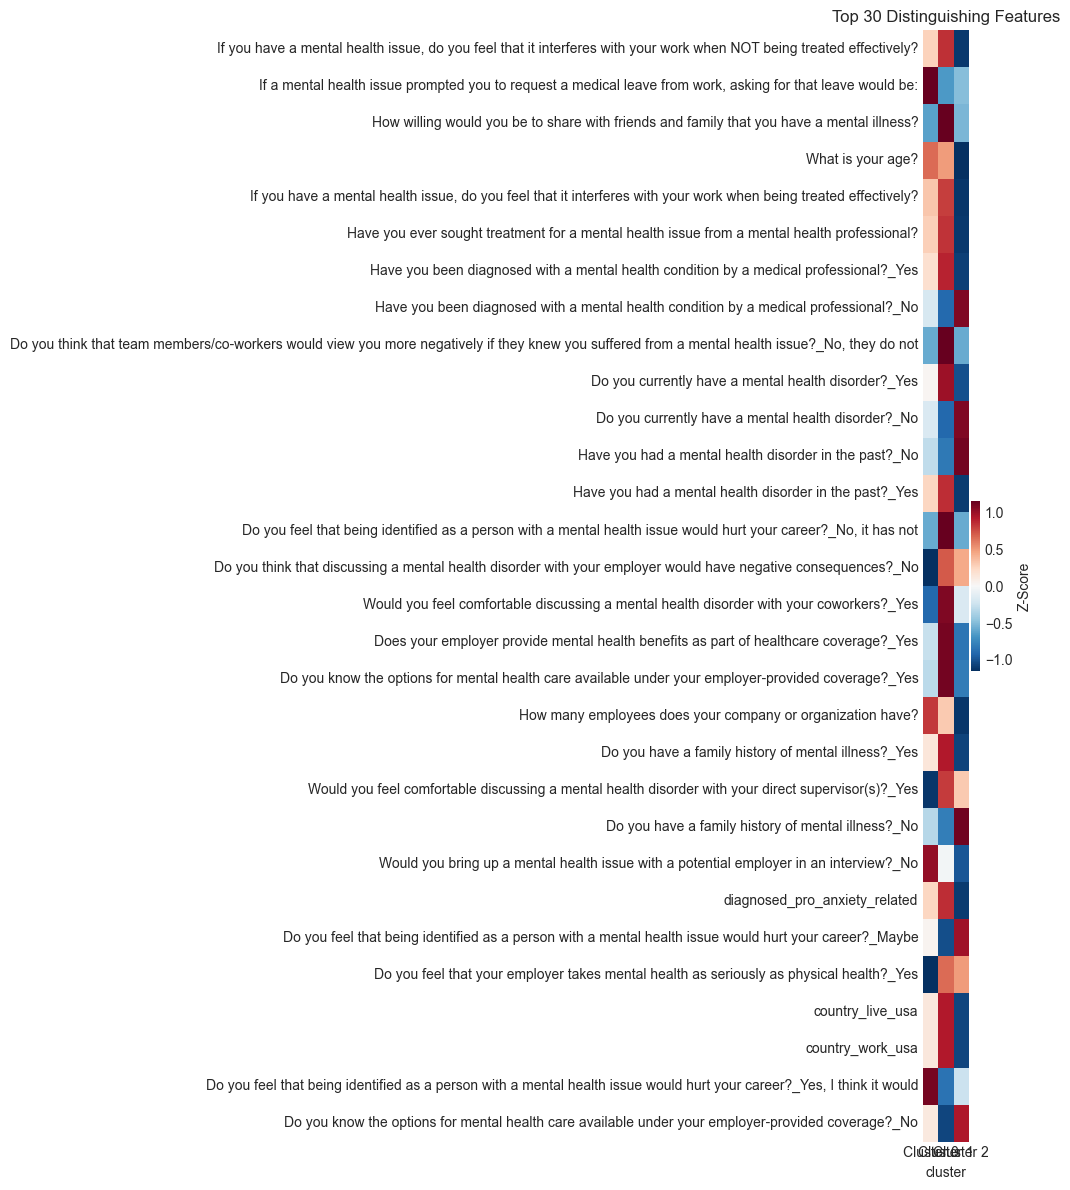

In [4]:
cluster_means = df.groupby('cluster')[feature_cols].mean()
cluster_means_norm = (cluster_means - cluster_means.mean()) / cluster_means.std()

top_features = cluster_means.var().nlargest(30).index.tolist()

fig, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(cluster_means_norm[top_features].T, cmap='RdBu_r', center=0,
            xticklabels=[f'Cluster {i}' for i in cluster_means.index],
            cbar_kws={'label': 'Z-Score'})
ax.set_title('Top 30 Distinguishing Features')
plt.tight_layout()
plt.savefig(f'../../plots/{RUN}/cluster_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Detailed Analysis: Most Distinguishing Features

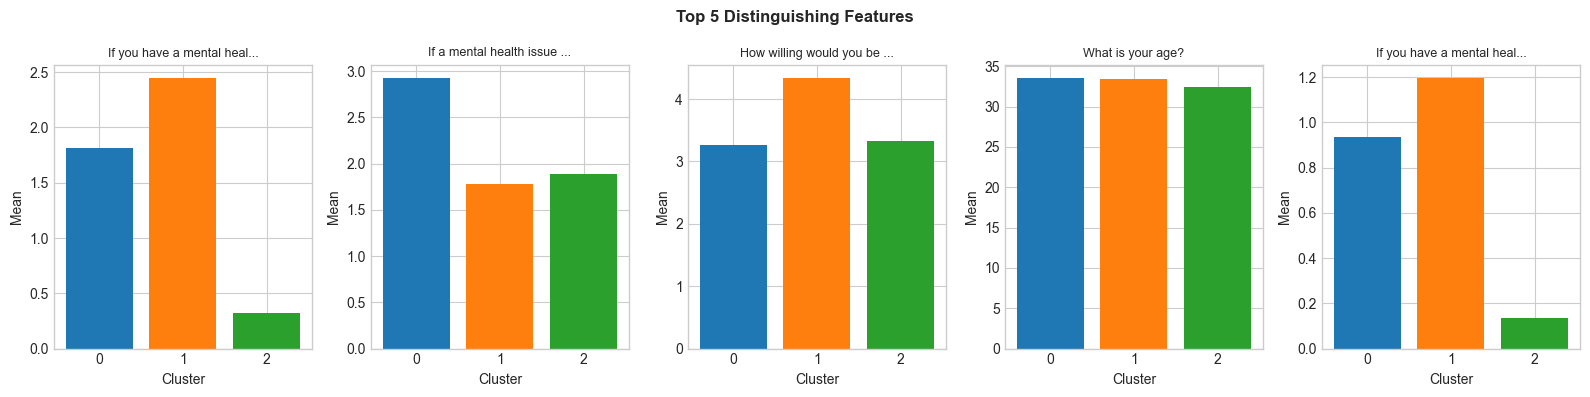

In [5]:
top_5_features = cluster_means.var().nlargest(5).index.tolist()

fig, axes = plt.subplots(1, 5, figsize=(16, 4))
for idx, feat in enumerate(top_5_features):
    means = cluster_means[feat]
    axes[idx].bar(means.index, means.values, color=plt.cm.tab10(range(len(means))))
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel('Mean')
    axes[idx].set_title(feat[:25] + '...' if len(feat) > 25 else feat, fontsize=9)

plt.suptitle('Top 5 Distinguishing Features', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(f'../../plots/{RUN}/top_features.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Mental Health Analysis per Cluster

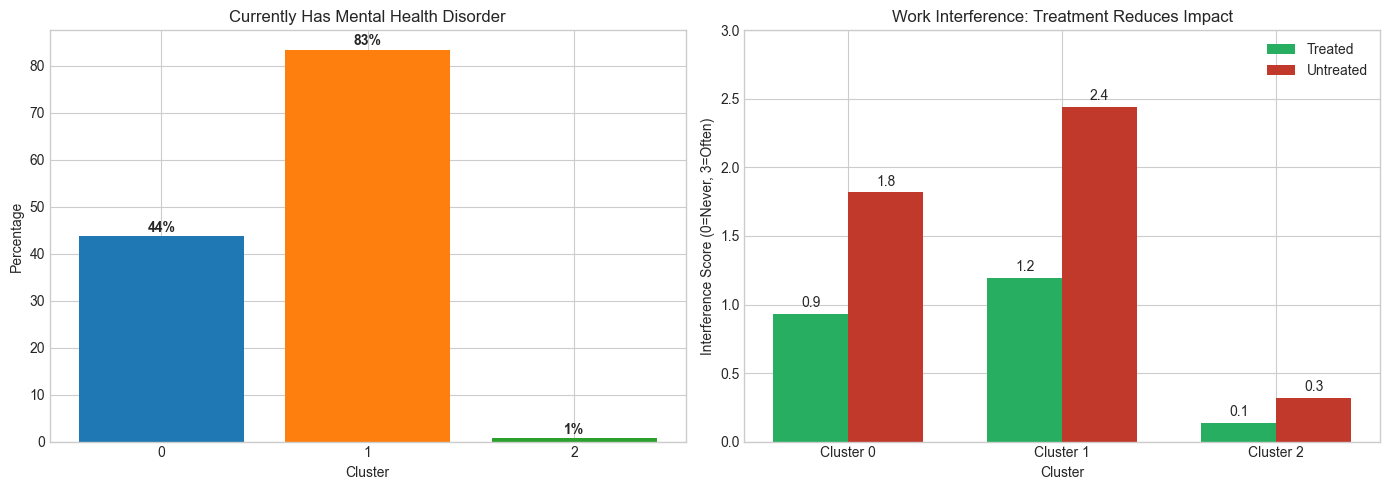

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Current MH Status per Cluster
ax1 = axes[0]
mh_status = df.groupby('cluster')['Do you currently have a mental health disorder?_Yes'].mean() * 100
bars = ax1.bar(mh_status.index, mh_status.values, color=plt.cm.tab10(range(len(mh_status))))
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Percentage')
ax1.set_title('Currently Has Mental Health Disorder')
ax1.set_xticks(mh_status.index)
for bar in bars:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{bar.get_height():.0f}%', ha='center', fontweight='bold')

# 2. Work Interference: Treated vs. Untreated (Key Insight!)
ax2 = axes[1]
col_treated = 'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?'
col_untreated = 'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?'

interference = df.groupby('cluster')[[col_treated, col_untreated]].mean()
x = np.arange(len(interference.index))
width = 0.35

bars1 = ax2.bar(x - width/2, interference[col_treated], width, label='Treated', color='#27ae60')
bars2 = ax2.bar(x + width/2, interference[col_untreated], width, label='Untreated', color='#c0392b')

ax2.set_xlabel('Cluster')
ax2.set_ylabel('Interference Score (0=Never, 3=Often)')
ax2.set_title('Work Interference: Treatment Reduces Impact')
ax2.set_xticks(x)
ax2.set_xticklabels([f'Cluster {i}' for i in interference.index])
ax2.legend()
ax2.set_ylim(0, 3)

for bar in bars1 + bars2:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, f'{bar.get_height():.1f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(f'../../plots/{RUN}/mental_health_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Workplace Attitudes per Cluster

## 8. Cluster Profiles (Radar Chart)

## 9. Cluster Summary

## 10. Statistical Significance of Cluster Differences

## 11. Recommendations for HR